In [33]:
%load_ext nb_black


import numpy as np

x_train = np.load("../test/139x139/x_train.npy")[:, :2, :2, :]
y_train = np.load("../test/139x139/y_train.npy")[:, :2, :2, :]
x_train = np.concatenate([x_train, y_train], axis=-1)[:-3]
y_train = y_train[3:]

x_test = np.load("../test/139x139/x_test.npy")[:, :2, :2, :]
y_test = np.load("../test/139x139/y_test.npy")[:, :2, :2, :]
x_test = np.concatenate([x_test, y_test], axis=-1)[:-3]
y_test = y_test[3:]

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [34]:
y_test.shape

(181, 2, 2, 1)

<IPython.core.display.Javascript object>

In [35]:
x_train.shape

(729, 2, 2, 7)

<IPython.core.display.Javascript object>

In [36]:
x_train = x_train.reshape(-1, 1, 28)
y_train = y_train.reshape(-1, 1, 4)

x_test = x_test.reshape(-1, 1, 28)
y_test = y_test.reshape(-1, 1, 4)

<IPython.core.display.Javascript object>

In [37]:
x_train.shape

(729, 1, 28)

<IPython.core.display.Javascript object>

In [38]:
def lstm():

    # inputs
    inputs = tf.keras.layers.Input(shape=(1, 28))
    x = tf.keras.layers.LSTM(units=256, return_sequences=True)(inputs)
    x = tf.keras.layers.Dense(4)(x)

    # build
    model = tf.keras.models.Model(inputs=inputs, outputs=x)

    # summary
    model.summary()

    return model

<IPython.core.display.Javascript object>

In [39]:
mdl = lstm()
mdl.compile(loss="mse", optimizer="adam")
mdl.fit(x_train, y_train, epochs=200, batch_size=128)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1, 28)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            291840    
_________________________________________________________________
dense_113 (Dense)            (None, 1, 4)              1028      
Total params: 292,868
Trainable params: 292,868
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
6/6 [==============================] - 1s 5ms/step - loss: 0.0102
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 

6/6 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 198/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 199/200
6/6 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 200/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0012


<IPython.core.display.Javascript object>

In [40]:
y_pred = mdl.predict(x_test)

<IPython.core.display.Javascript object>

In [41]:
from sklearn.metrics import r2_score, mean_squared_error

for i in range(4):
    print(r2_score(y_test[:, 0, i], y_pred[:, 0, i]))
# print(np.sqrt(mean_squared_error(y_test[i, :], m[i,:])))

0.6545411330449097
0.3920237295224953
0.30274736860276585
0.39341670730621703


<IPython.core.display.Javascript object>

In [14]:
from model.clstm_v1 import CausalLSTM
from model.tree_causality import CausalTree
import time
import tensorflow as tf

def clstm_v1():
    """CLSTM Version 1."""
    
    feature_params = ['a','b','c','d','e','f','g']

    ct = CausalTree(
        num_features=len(feature_params),
        name_features=feature_params,
        corr_thresold=0.5,
        mic_thresold=0.5,
        flag=[1,0,0],
        depth=2
    )
    children, child_input_idx, child_state_idx = ct(np.array(np.squeeze(np.nanmean(x_train, axis=(1,2)))))

    inputs = tf.keras.layers.Input(shape=(1, 28))
    x = CausalLSTM(
        num_nodes=len(children),
        num_hiddens=256,
        num_out=4,
        children=children,
        child_input_idx=child_input_idx,
        child_state_idx=child_state_idx,
        len_inputs=1)(inputs)

    # build
    model = tf.keras.models.Model(inputs=inputs, outputs=x)

    # summary
    model.summary()

    return model

mdl = clstm_v1()

mdl.compile(
    optimizer='adam',
    loss=['mse']
)


history_clstm = mdl.fit(
    x_train.reshape(729, 1, 4*7), y_train.reshape(729, 1, 4),#train_data,
    batch_size=128,
    epochs=200
)


get adjacency matrix
This case do not use mic!
...done...
turn adjacency matrix to tree causality
1
2
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
{'1': [[6]], '2': [[3]], '3': [[4, 6]]}
...done...
get input tree structure of Causal LSTM
[[4], [6], [3], [6]]
2
1
[0, 0, 2, 1]
...done...
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 28)]           0         
_________________________________________________________________
causal_lstm_2 (CausalLSTM)   (None, 1, 4)              1832196   
Total params: 1,832,196
Trainable params: 1,832,196
Non-trainable params:

6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 190/200
6/6 [==============================] - 0s 28ms/step - loss: 0.0011
Epoch 191/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 192/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 193/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 194/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 195/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 196/200
6/6 [==============================] - 0s 29ms/step - loss: 0.0011
Epoch 197/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 198/200
6/6 [==============================] - 0s 28ms/step - loss: 0.0011
Epoch 199/200
6/6 [==============================] - 0s 27ms/step - loss: 0.0011
Epoch 200/200
6/6 [==============================] - 0s 28ms/step - loss: 0.0011


<IPython.core.display.Javascript object>

In [16]:
y_pred_clstm = mdl(x_test.reshape(181, 1, 28))
y_test

array([[[[0.29668677],
         [0.28574622]],

        [[0.31182349],
         [0.28373206]]],


       [[[0.26649025],
         [0.2183793 ]],

        [[0.23487405],
         [0.21524362]]],


       [[[0.22134103],
         [0.16022195]],

        [[0.16782083],
         [0.15395822]]],


       [[[0.22465582],
         [0.15288611]],

        [[0.15934058],
         [0.14529486]]],


       [[[0.24847378],
         [0.18373838]],

        [[0.18712583],
         [0.17072263]]],


       [[[0.31599608],
         [0.28367797]],

        [[0.30095091],
         [0.2857379 ]]],


       [[[0.25009191],
         [0.18450201]],

        [[0.18213689],
         [0.18176305]]],


       [[[0.23007295],
         [0.15932557]],

        [[0.15689179],
         [0.15284058]]],


       [[[0.24515159],
         [0.16865166]],

        [[0.16923912],
         [0.16080101]]],


       [[[0.23267594],
         [0.15388718]],

        [[0.1566948 ],
         [0.1461052 ]]],


       [[[0.23414674

<IPython.core.display.Javascript object>

In [17]:
y_pred_clstm.shape

TensorShape([181, 1, 4])

<IPython.core.display.Javascript object>

In [18]:
from sklearn.metrics import r2_score, mean_squared_error

for i in range(6):
    print(r2_score(y_test.reshape(181, 1, 4)[:, 0, i], y_pred_clstm[:, 0, i]))
# print(np.sqrt(mean_squared_error(y_test[i, :], m[i,:])))

0.6583480626254348
0.4213624717269374
0.33592558069376144
0.37846663077573983


IndexError: index 4 is out of bounds for axis 2 with size 4

<IPython.core.display.Javascript object>

In [7]:
547-128-128-128-128

35

In [2]:
from model.__model import train, RMSELoss, GlobalLSTM

model = GlobalLSTM(hidden_size=256)
loss_func = RMSELoss()
model = train(model, x_train, y_train, loss_func, epochs=500)

epoch: 1, loss: 0.10499287396669388, time: 3.553032398223877
epoch: 2, loss: 0.05705791339278221, time: 3.4356863498687744
epoch: 3, loss: 0.044096771627664566, time: 3.3920505046844482
epoch: 4, loss: 0.03604292497038841, time: 3.429745674133301
epoch: 5, loss: 0.031047850847244263, time: 3.49320387840271
epoch: 6, loss: 0.027486030012369156, time: 3.2279059886932373
epoch: 7, loss: 0.02533257193863392, time: 3.4585084915161133
epoch: 8, loss: 0.023775290697813034, time: 3.516453266143799
epoch: 9, loss: 0.022927919402718544, time: 3.329618215560913
epoch: 10, loss: 0.023672688752412796, time: 3.388010263442993
epoch: 11, loss: 0.021688761189579964, time: 3.4612057209014893
epoch: 12, loss: 0.02161685936152935, time: 3.6233534812927246
epoch: 13, loss: 0.021016251295804977, time: 3.4382357597351074
epoch: 14, loss: 0.020833676680922508, time: 3.350468397140503
epoch: 15, loss: 0.019584327936172485, time: 3.2938170433044434
epoch: 16, loss: 0.02015121839940548, time: 3.647838830947876


epoch: 131, loss: 0.012044457718729973, time: 3.5522069931030273
epoch: 132, loss: 0.011780292727053165, time: 3.422316551208496
epoch: 133, loss: 0.011924502439796925, time: 3.4204299449920654
epoch: 134, loss: 0.012314491905272007, time: 3.549318790435791
epoch: 135, loss: 0.011880754493176937, time: 3.475339412689209
epoch: 136, loss: 0.012177797965705395, time: 3.3591926097869873
epoch: 137, loss: 0.011733908206224442, time: 3.512347459793091
epoch: 138, loss: 0.01216364186257124, time: 3.4350337982177734
epoch: 139, loss: 0.011738174594938755, time: 3.453200340270996
epoch: 140, loss: 0.011527229100465775, time: 3.329998731613159
epoch: 141, loss: 0.012100180611014366, time: 3.462064743041992
epoch: 142, loss: 0.011830064468085766, time: 3.506915330886841
epoch: 143, loss: 0.012073689140379429, time: 3.4555928707122803
epoch: 144, loss: 0.012116139754652977, time: 3.4074437618255615
epoch: 145, loss: 0.011684727855026722, time: 3.467062473297119
epoch: 146, loss: 0.011760166846215

epoch: 259, loss: 0.010998353362083435, time: 3.692920446395874
epoch: 260, loss: 0.01085379347205162, time: 3.9721245765686035
epoch: 261, loss: 0.011259007267653942, time: 4.011292934417725
epoch: 262, loss: 0.01107160747051239, time: 4.011821269989014
epoch: 263, loss: 0.01117276307195425, time: 3.754645586013794
epoch: 264, loss: 0.011143822222948074, time: 3.7355213165283203
epoch: 265, loss: 0.010987168177962303, time: 4.021031618118286
epoch: 266, loss: 0.011280225589871407, time: 4.010220289230347
epoch: 267, loss: 0.010842950083315372, time: 3.829146385192871
epoch: 268, loss: 0.011632271111011505, time: 4.104304075241089
epoch: 269, loss: 0.011176791042089462, time: 3.5029563903808594
epoch: 270, loss: 0.011045020073652267, time: 3.432385206222534
epoch: 271, loss: 0.011714889667928219, time: 3.514976978302002
epoch: 272, loss: 0.01128311175853014, time: 3.498523473739624
epoch: 273, loss: 0.011259716004133224, time: 3.534147024154663
epoch: 274, loss: 0.010870874859392643, t

epoch: 387, loss: 0.010410336777567863, time: 3.441685438156128
epoch: 388, loss: 0.011187538504600525, time: 3.606813669204712
epoch: 389, loss: 0.011314231902360916, time: 3.5872554779052734
epoch: 390, loss: 0.011077105067670345, time: 3.5426104068756104
epoch: 391, loss: 0.011046906001865864, time: 3.5366933345794678
epoch: 392, loss: 0.010735787451267242, time: 3.6094422340393066
epoch: 393, loss: 0.010496541857719421, time: 3.4967195987701416
epoch: 394, loss: 0.01094452477991581, time: 3.288327693939209
epoch: 395, loss: 0.010642679408192635, time: 3.30644154548645
epoch: 396, loss: 0.010328378528356552, time: 3.349781036376953
epoch: 397, loss: 0.010944308713078499, time: 3.5032565593719482
epoch: 398, loss: 0.010260681621730328, time: 3.3540501594543457
epoch: 399, loss: 0.010843939147889614, time: 3.461179494857788
epoch: 400, loss: 0.010868582874536514, time: 3.474987506866455
epoch: 401, loss: 0.010746940039098263, time: 3.481656789779663
epoch: 402, loss: 0.010475399903953

In [17]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model(x_test)

for i in range(6):
    print(np.corrcoef(np.squeeze(y_test[i,:]), np.squeeze(y_pred[i,:]))[0,1])
    print(r2_score(np.squeeze(y_test[i,:]), np.squeeze(y_pred[i,:])))
    print(np.sqrt(mean_squared_error(np.squeeze(y_test[i,:]), np.squeeze(y_pred[i,:]))))

0.7591338885955432
-0.762721021696239
0.023620606013798954
0.7749346527378639
-6.215072691236134
0.06332248121387651
0.809571474369686
0.5340896357256666
0.013407576136174985
0.7996880000259347
0.46030252783176406
0.015300364985777862
0.8341491003759628
0.6491357021128907
0.012113223475553428
0.8288526462339292
0.6261346073303159
0.01280288823901347


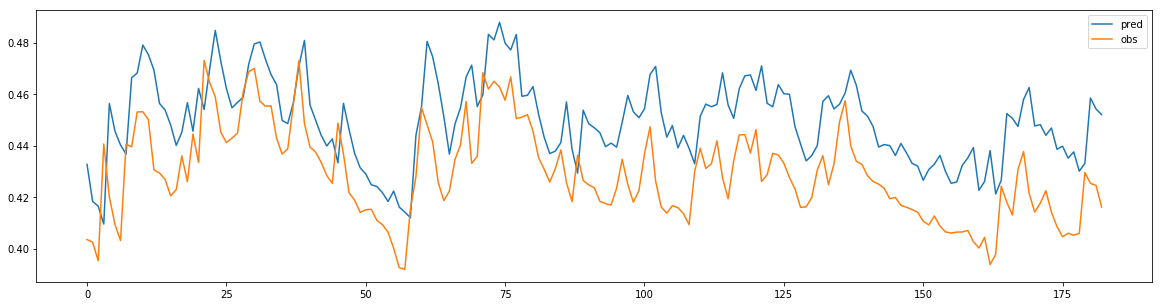

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(y_pred[0])
plt.plot(y_test[0])
plt.legend(['pred','obs'])

In [ ]:
from model.__model import GlobalLSTM
from model.__train_model import train, rmse_loss

model = GlobalLSTM(256)

model = train(model,
      x_train,
      y_train,
      loss_func=rmse_loss,
      epochs=10,
      batch_size=6,
      rho=30)
model.train(mode=False)
import torch
x_test = torch.Tensor(x_test).float().cuda()
#x_test = torch.from_numpy(x_test_)
yp = model(x_test)
m = np.array(yp.cuda().data.cpu().numpy())

tf.Tensor(98.96568, shape=(), dtype=float32)
epoch 0: MSE is 0.43028557300567627, cost time: 18.514955043792725
tf.Tensor(67.82648, shape=(), dtype=float32)
epoch 1: MSE is 0.29489773511886597, cost time: 17.77572202682495


In [6]:
from sklearn.metrics import r2_score, mean_squared_error
for i in range(6):
    print(r2_score(y_test[i,:], m[i,:]))
    print(np.sqrt(mean_squared_error(y_test[i, :], m[i,:])))

0.5688472301594292
0.011681936308393818
0.598348267244182
0.014940405702957366
0.6797533918444221
0.011115816156268851
0.32518909213192093
0.017108725012636463
0.7068575821064038
0.01107208657374262
0.6825446798301638
0.011797544557035109


In [34]:
from postprocess._matrix_to_raster import Matrix2Raster


im_proj, im_geotrans, data = Matrix2Raster().read_img('soilMoisture2.tif')
f = nc.Dataset('/hard/lilu/SMAP_L4/test/SMAP_L4_DD/SMAP_L4_SSM_20150531.nc')
Matrix2Raster().write_img('a.tif', im_proj, im_geotrans, data1)

123
125


In [14]:
data.shape

(452, 780)

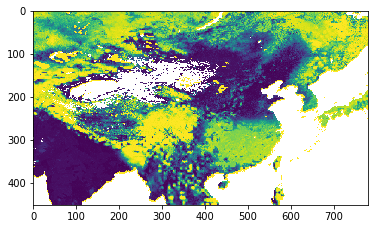

In [15]:
import matplotlib.pyplot as plt

plt.imshow(data)

In [23]:
import netCDF4 as nc
import numpy as np

In [24]:
f = nc.Dataset('/hard/lilu/SMAP_L4/test/SMAP_L4_DD/SMAP_L4_SSM_20150531.nc')

In [25]:
data1 = np.array(f['ssm'])

In [26]:
data1.shape

(413, 750)

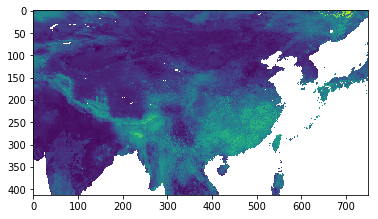

In [27]:
plt.imshow(data1)

In [28]:
Matrix2Raster().write_img('a.tif', im_proj, im_geotrans, data1)

In [29]:
im_proj, im_geotrans, data3 = Matrix2Raster().read_img('a.tif')

750
413


In [31]:
data3.shape

(413, 750)

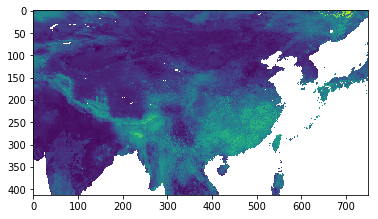

In [32]:
plt.imshow(data3)

In [28]:
import numpy as np


r2 = np.load('r2_convlstm_1layer.npy')
r2_wandb = np.load('r2_convlstm_1layer_wandb.npy')
r2_3 = np.load('r2_convlstm_wandb.npy')
r2_4 = np.load('r2_unet_wandb.npy')
mask = np.load('mask.npy')

"\na = np.multiply(r2_4-r2_wandb,mask[:112,:112])\na[a==0] = np.nan\nplt.imshow(a, vmin=0, vmax=1, cmap='jet')\nplt.colorbar()\n"

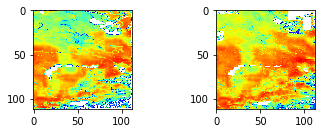

In [33]:
import matplotlib.pyplot as plt

r2[r2==0] = np.nan
r2_4[r2_4==0] = np.nan

plt.subplot(2,2,1)
plt.imshow(r2, vmin=0, vmax=1, cmap='jet')
plt.subplot(2,2,2)
plt.imshow(r2_4, vmin=0, vmax=1, cmap='jet')

"""
a = np.multiply(r2_4-r2_wandb,mask[:112,:112])
a[a==0] = np.nan
plt.imshow(a, vmin=0, vmax=1, cmap='jet')
plt.colorbar()
"""

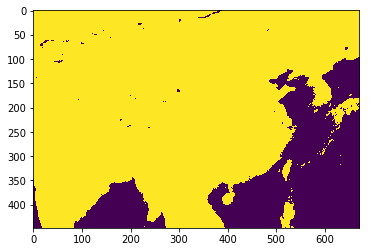

In [19]:
plt.imshow(mask)

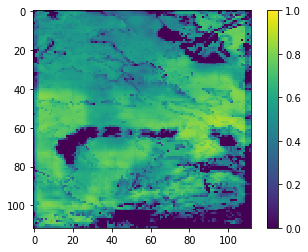

In [13]:
plt.imshow(r2_3, vmin=0, vmax=1)
plt.colorbar()